# Predicting Default of SBA 7(a) Loans Using Historical Data Disclosed Under FOIA

The Small Business Administration (SBA) was founded in 1953 to help small businesses obtain loans. Rather than lending to small businesses directly, the SBA improves a business's odds of getting a loan by limiting the exposure of approved lenders though guaranteeing a portion of the loan. This allows small businesses that might not have otherwise been able to secure funding to recieve approval. 

The SBA records loan applications and their current status for hundreds of thousands of small businesses. As a government agency, under the Freedom of Information Act (FOIA), the SBA is obligated to disclose certain information about loan applications such as the name of the company a loan was given to, the amount of the loan, the duration of the loan, and the initial intrest rate. The status of *past loans* is also reported. However, the status of *current loans* is exempt from reporting under FOIA section 4, since such information reveals significant details about the current financial status of a company. Therefore, while data for the status of current SBA loans is not generally available, it is possible examine historical data for loans in an attempt to predict whether current loans will default or not.

This paper develops a machine learning model to predict the end status of a SBA supported loan, which is classified as either paid-in-full or defaulted, where defaulted indicates that the full value of the loan was not paid back by the small business.

# Sourcing The Data

The SBA provides two types of assisted loans to small businesses. The SBA 504 loan program provides long-term, fixed-rate financing for fixed assets like real estate or equipment. These loans are typically offered to expanding businesses. In contrast, the SBA 7(a) loan program offers more flexibility, allowing businesses to use the funds for a wide range of purposes, including working capital, purchasing inventory, and refinancing debt, with loans coming directly from participating lenders.

The FOIA Data sets for both loans offerings are listed on the SBAs website at [https://data.sba.gov/dataset/7-a-504-foia]. In this paper we consider the 7(a) loan offering since the dataset is more comprehensive, and in the hopes that shorter term length of the loans allows us to develop a more accurate model; i.e., we assume that it is more difficult to predict if a loan will default in the next 20 years that it is to predict if it will default in the next 2 years

The 7(a) FOIA datasets covering loan information from 2000-2009, 2010-2020, and 2020-present (all updated in June 20th, 2024) can be read in and saved as a CSV file as follows:

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

# This code sources the data, but as it is subject to unstable changes, we load the data 
# df1 = pd.read_csv("https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/186eb176-b53e-4cbe-ab93-e5c4fb50197d/download/foia-7afy2000-fy2009-asof-240630.csv")
# df1.to_csv("../data/SBA_7a_2000-2009.csv", index=False)
# df2 = pd.read_csv("https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/5afaa348-03b9-4374-942d-3c7881b4fc54/download/foia-7afy2010-fy2019-asof-240630.csv")
# df2.to_csv("../data/SBA_7a_2010-2020.csv", index=False)
# df3 = pd.read_csv("https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/883f1ad6-b683-4c30-ba4a-76b20a08bdd4/download/foia-7afy2020-present-asof-240630.csv")
# df3.to_csv("../data/SBA_7a_2020-present.csv", index=False)

df1 = pd.read_csv("../data/SBA_7a_2000-2009.csv")
df2 = pd.read_csv("../data/SBA_7a_2010-2020.csv")
df3 = pd.read_csv("../data/SBA_7a_2020-present.csv")

/var/folders/x6/xstr5ys90n7ffprv8p5rknqr0000gn/T/ipykernel_27704/3700477919.py:14: DtypeWarning: Columns (13,22,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("../data/SBA_7a_2000-2009.csv")
/var/folders/x6/xstr5ys90n7ffprv8p5rknqr0000gn/T/ipykernel_27704/3700477919.py:15: DtypeWarning: Columns (13,33) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("../data/SBA_7a_2010-2020.csv")
/var/folders/x6/xstr5ys90n7ffprv8p5rknqr0000gn/T/ipykernel_27704/3700477919.py:16: DtypeWarning: Columns (36) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("../data/SBA_7a_2020-present.csv")


### Observation from Priliminary EDA and Target Column Summary Statistics

The combined dataset is fairly large, spanning more than a million data points with about 41 columns. The columns 'catalog_month' and 'catalog_year' in the 2000-2009 data are not supported by 2010-present data. As a results, they will be dropped before merging the dataframes. In addition, the first column in each dataframe is 'AsOfDate", and corresponds to 06/30/2024 for all values. Lastly, it is observed that the majority of loans from the 2000-2009 dataset are completed -- i.e., not marked as exempt -- where the more recent loans are not completed and therefore marked as exempt. This makes sense since older loans are more likely to have been paid back in full or defaulted on.

# Dataset Cleaning and Feature Engineering

### 1. Merge The Datasets

To merge both datasets, assign consistent column names to df1, df2, df3. Drop the AsOfDate and Program from each dataframe since this information will not be usefull to a machine learning model (It is identical for all values) and can be recovered by recalling that the dataset is from 06/30/2024 and the 7a loan program. Then, merge dropping duplicates to ensure that there is no data repetition. 

In [2]:
column_names = list(df2.columns)
df1.columns = column_names
df2.columns = column_names
df3.columns = column_names

df1 = df1.drop(["AsOfDate", "Program"], axis=1)
df2 = df2.drop(["AsOfDate", "Program"], axis=1)
df3 = df3.drop(["AsOfDate", "Program"], axis=1)
df = pd.concat([df1, df2, df3]).drop_duplicates()

print("We observe the following about the merged dataset:")
print("Total Rows   : " + str(df.shape[0]))
print("Total Columns: " + str(df.shape[1]))
print("Column Names : " + str(list(df.columns)))


print("\n")
print(df["LoanStatus"].value_counts())

df.to_csv("../data/merged.csv", index=False)

We observe the following about the merged dataset:
Total Rows   : 1503934
Total Columns: 39
Column Names : ['BorrName', 'BorrStreet', 'BorrCity', 'BorrState', 'BorrZip', 'BankName', 'BankFDICNumber', 'BankNCUANumber', 'BankStreet', 'BankCity', 'BankState', 'BankZip', 'GrossApproval', 'SBAGuaranteedApproval', 'ApprovalDate', 'ApprovalFiscalYear', 'FirstDisbursementDate', 'DeliveryMethod', 'Subprogram', 'InitialInterestRate', 'FixedOrVariableInterestInd', 'TermInMonths', 'NaicsCode', 'NaicsDescription', 'FranchiseCode', 'FranchiseName', 'ProjectCounty', 'ProjectState', 'SBADistrictOffice', 'CongressionalDistrict', 'BusinessType', 'BusinessAge', 'LoanStatus', 'PaidInFullDate', 'ChargeOffDate', 'GrossChargeOffAmount', 'RevolverStatus', 'JobsSupported', 'SoldSecMrktInd']


LoanStatus
PIF       858771
EXEMPT    268653
CHGOFF    178777
CANCLD    173013
COMMIT     24720
Name: count, dtype: int64


### 2.) Drop Hyperspecific Columns

Second, drop the hyperspecific data columns. In this context, these columns are hyperspecific location oriented information, like street and business names. The dataset is not large enough to draw conclusions off of a particular street name, and so we instead use the city to denote this information. 

In [3]:
print(df['BorrStreet'].value_counts())
print("\n")
print(df['BankStreet'].value_counts())

df = df.drop(["BorrStreet", "BorrName", "BankStreet", "BankFDICNumber", "BankNCUANumber", "FranchiseName", "NaicsDescription"], axis=1)

BorrStreet
TBD                            117
MAIN STREET                     68
Main Street                     54
358 PINE STREET                 44
TO BE DETERMINED                43
                              ... 
9200 Westheimer Ste 1111 Rd      1
187 10th Street                  1
807 E Aultman St                 1
805 ORPAX ST                     1
2471 HERRING WOODS TRL           1
Name: count, Length: 1311562, dtype: int64


BankStreet
101 N Philips Ave          92129
100 N Tryon St, Ste 170    86169
1111 Polaris Pkwy          81066
17 S High St.              76312
425 Walnut St              67601
                           ...  
5309 Highgate Dr               1
4343 E Sunset Rd               1
5238 W Seneca St               1
4415 71st St, Ste 11           1
200 Capitol St                 1
Name: count, Length: 5162, dtype: int64


### 3.) Drop Columns Which Will Be Unavailable To The Deployed Model

Drop columns that will be unavailable to the deployed model. For example, in this data set, the columns "PaidInFullDate", "ChargeOffDate", and "GrossChargeOffAmount" are usefull pieces of information. However, they directly correspond to PIF, CHGOFF, and CHGOFF respectivly. In other words, the end result of what we are trying to predict (PIF or CHGOFF) must be known ahead of time for these columns to exist. The same is true for SoldSecMrktInd, which indicates if the loan was sold, which frequently indicates default and can only be known on a time series basis and the date of the entry for this indicator is known. Therefore, they cannot be included in the training or testing data without leaking information, and must be removed.

In [4]:
df['FinalStatusDate'] = df['PaidInFullDate'].fillna(df['ChargeOffDate']) # Convert 'PaidInFullDate' and 'ChargeOffDate' to a single value, indicating when the loan was completed
df = df.drop(["GrossChargeOffAmount", 'PaidInFullDate', 'ChargeOffDate', 'SoldSecMrktInd'], axis=1) # Drop unrealistic columns

### 4.) Generate and Generalize Industry Classification

Lastly, there are columns for which generalization is useful. The "NaicsCode" (North American Industry Classification System Code) provides a hyperspecific labeling of the type of business that the company applying of the loan conducts. For example "NaicsCode" 561621 refers to Security Systems Services (except Locksmiths) as opposed to "NaicsCode" 561612 which refers to Security Guards and Patrol Services. While this hyperspecific information is very useful, more general information about the industry type -- e.g., manufacturing vs service vs merchandising -- would also be useful to be able to help train the model on more general attributes as well. 

In [5]:
# The following naics_mappings are obtained from 
# The US census at https://www.census.gov/naics/?58967?yearbck=2022
# and expressed in condensed form
naics_mapping = {
        "11": "Agriculture",
        "21": "Mining",
        "22": "Utilities",
        "23": "Construction",
        "31": "Manufacturing",
        "32": "Manufacturing",
        "33": "Manufacturing",
        "42": "Wholesale",
        "44": "Retail",
        "45": "Retail",
        "48": "Transportation",
        "49": "Transportation",
        "51": "Information",
        "52": "Finance",
        "53": "Real Estate, Rental and Leasing",
        "54": "Professional Services",
        "55": "Management",
        "56": "Administrative, Waste Management and Cleaning Services",
        "61": "Educational Services",
        "62": "Health Care and Social Assistance",
        "71": "Arts, Entertainment, and Recreation",
        "72": "Accommodation and Food Services",
        "81": "Other Services",
        "92": "Public Administration",
    }
    
for code_prefix, business_type in naics_mapping.items():
    df[business_type] = df["NaicsCode"].astype(str).str.startswith(code_prefix).astype(int)

for code_prefix, business_type in naics_mapping.items():
    print(df[business_type].value_counts())

df['FranchiseCode'] = df['FranchiseCode'].notna().astype(int)

Agriculture
0    1487359
1      16575
Name: count, dtype: int64
Mining
0    1500624
1       3310
Name: count, dtype: int64
Utilities
0    1502520
1       1414
Name: count, dtype: int64
Construction
0    1352124
1     151810
Name: count, dtype: int64
Manufacturing
0    1443435
1      60499
Name: count, dtype: int64
Manufacturing
0    1443435
1      60499
Name: count, dtype: int64
Manufacturing
0    1443435
1      60499
Name: count, dtype: int64
Wholesale
0    1423917
1      80017
Name: count, dtype: int64
Retail
0    1433408
1      70526
Name: count, dtype: int64
Retail
0    1433408
1      70526
Name: count, dtype: int64
Transportation
0    1498103
1       5831
Name: count, dtype: int64
Transportation
0    1498103
1       5831
Name: count, dtype: int64
Information
0    1483839
1      20095
Name: count, dtype: int64
Finance
0    1479164
1      24770
Name: count, dtype: int64
Real Estate, Rental and Leasing
0    1470573
1      33361
Name: count, dtype: int64
Professional Services
0    136

### 5.) Convert Date Formats to Numerical Values

If we inspect the types of a number of date formats such as FirstDisbursementDate, we see that due to excel formatting, some dates are denoted as XX/XX/XX and others as integers which use the excel formatting for dates (number of hours since 1899-12-30). To ensure that this data is displayed correctly, we convert it all from the excel format to the correct XX/XX/XXXX format, and then convert this format to a numerical value which will be easier to train a model on, namely the number of days since Jan 1st 2000.

In [6]:
from datetime import datetime, timedelta

def excel_dates_to_datetime(df, column_name):
    base_date = datetime(1899, 12, 30)
    mask = df[column_name].apply(lambda x: isinstance(x, int))
    df.loc[mask, column_name] = df.loc[mask, column_name].apply(lambda x: base_date + timedelta(days=x))


excel_dates_to_datetime(df, "ApprovalDate")
df["ApprovalDate"] = pd.to_datetime(df["ApprovalDate"], errors='coerce').dt.strftime('%m/%d/%Y')

excel_dates_to_datetime(df, "FirstDisbursementDate")
df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"], errors='coerce').dt.strftime('%m/%d/%Y')

excel_dates_to_datetime(df, "FinalStatusDate")
df["FinalStatusDate"] = pd.to_datetime(df["FinalStatusDate"], errors='coerce').dt.strftime('%m/%d/%Y')



print(df["ApprovalDate"].value_counts())
print(df["FirstDisbursementDate"].value_counts())
print(df["FinalStatusDate"].value_counts())

reference_date = datetime(2000, 1, 1)

df["ApprovalDate"] = pd.to_datetime(df["ApprovalDate"], format='%m/%d/%Y', errors='coerce').apply(
    lambda x: (x - reference_date).days if not pd.isnull(x) else None
)

df["FirstDisbursementDate"] = pd.to_datetime(df["FirstDisbursementDate"], format='%m/%d/%Y', errors='coerce').apply(
    lambda x: (x - reference_date).days if not pd.isnull(x) else None
)

df["FinalStatusDate"] = pd.to_datetime(df["FinalStatusDate"], format='%m/%d/%Y', errors='coerce').apply(
    lambda x: (x - reference_date).days if not pd.isnull(x) else None
)

print(df["ApprovalDate"].value_counts())
print(df["FirstDisbursementDate"].value_counts())
print(df["FinalStatusDate"].value_counts())

ApprovalDate
03/11/2010    1489
07/28/2015    1341
01/30/2004    1242
10/01/2010    1067
09/27/2023     998
              ... 
12/02/2018       1
08/02/2015       1
01/17/2015       1
02/23/2019       1
04/19/2015       1
Name: count, Length: 8022, dtype: int64
FirstDisbursementDate
03/31/2006    7268
04/30/2007    7195
08/31/2007    7017
10/31/2007    6928
05/31/2007    6909
              ... 
09/07/2006       1
01/18/2006       1
05/04/2006       1
02/08/2020       1
10/18/2024       1
Name: count, Length: 6394, dtype: int64
FinalStatusDate
05/31/2005    46950
07/31/2005     8833
08/31/2012     8150
03/31/2022     5544
02/28/2022     5421
              ...  
07/09/2004        1
09/28/2003        1
05/23/2005        1
04/06/2001        1
11/12/2022        1
Name: count, Length: 6001, dtype: int64
ApprovalDate
3722    1489
5687    1341
1490    1242
3926    1067
8670     998
        ... 
6910       1
5692       1
5495       1
6993       1
5587       1
Name: count, Length: 8022, dtype: i

### 6.) Convert Invalid Rows

Three columns are currently giving erros due to mixed types. These are converted as follows:

In [7]:
# First, drop the small number of incomplete rows:
print(df.shape)
df['BusinessAge'] = df['BusinessAge'].fillna('Unknown')
print(df['BusinessAge'].value_counts())

(1503934, 49)
BusinessAge
Unknown                                   1123493
Existing or more than 2 years old          197329
Startup, Loan Funds will Open Business      63390
New Business or 2 years or less             46222
Change of Ownership                         38568
Unanswered                                  22462
Existing, 5 or more years                    7183
New, Less than 1 Year old                    2383
Less than 3 years old but at least 2         1168
Less than 4 years old but at least 3          928
Less than 5 years old but at least 4          808
Name: count, dtype: int64


### 7.) Drop Irrelevant Rows

Drop rows for companies who did not discharge or pay back their loans in full. These are the rows that the model will be deployed on or are otherwise irrelevant (i.e., applied but did not follow through, or pending approval).

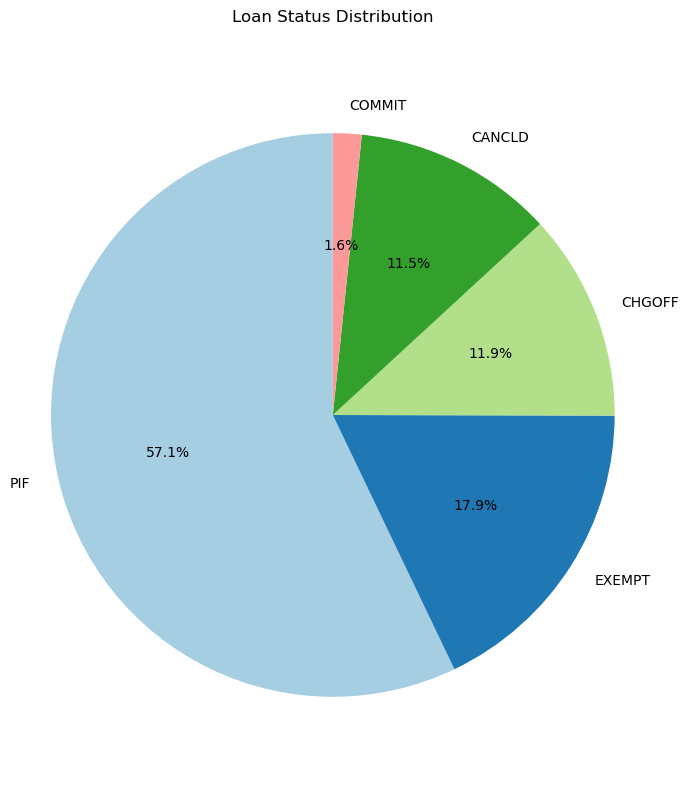

LoanStatus
PIF       858771
EXEMPT    268653
CHGOFF    178777
CANCLD    173013
COMMIT     24720
Name: count, dtype: int64


In [8]:
loan_status_counts = df["LoanStatus"].value_counts()

plt.figure(figsize=(8, 10))
plt.pie(loan_status_counts, labels=loan_status_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
plt.title('Loan Status Distribution')
plt.axis('equal')
plt.show()

print(loan_status_counts)

df_cleaned = df[df["LoanStatus"].isin(["PIF", "CHGOFF"])]


### 8.) For Columns with Very Few Missing Values, Drop the Corresponding Rows

With a large dataset of nearly a million rows, for columns with less than 500 missing values, we can drop the corresponding rows without siginficant data loss, taking into account that the missing values likely come from data inputting errors.

In [9]:
for column in df_cleaned.columns:
    na_values = df_cleaned[df_cleaned[column].isna()]
    if na_values.shape[0] <= 500 and na_values.shape[0] > 0:
        print(column)
        df_cleaned = df_cleaned.drop(na_values.index)

BorrCity
BankCity
BankState
FinalStatusDate


### 9.) Indicating Missing Values for Ordinal and Continuous Data

For the continous columns 'FirstDisbursementDate' and 'InitialInterestRate', there are at least 100,000 missing values. To ensure that the presence of data is denoted we record with a 1 in 'FirstDisbursementDateUnknown' and 'InitialInterestRateUnknown' if these values are not known to the model at the time of training

In [10]:
df_cleaned["FirstDisbursementDate"] = df_cleaned["FirstDisbursementDate"].fillna(
    df_cleaned["ApprovalDate"] + 14
)

df_cleaned["InitialInterestRate"] = df_cleaned["InitialInterestRate"].apply(
    lambda x: (
        "Unknown" if pd.isnull(x) else
        "Very Low" if x <= 2.75 else
        "Low" if x <= 5.5 else
        "Below Average" if x <= 6.0 else
        "Above Average" if x <= 7.4 else
        "High" if x <= 9.1 else 
        "Very High"
    )
)

df_cleaned["CongressionalDistrict"] = df_cleaned["CongressionalDistrict"].fillna(-1)
df_cleaned['FixedOrVariableInterestInd'] = (df_cleaned['FixedOrVariableInterestInd'] == 'F').astype(int)

### 10.) Compute Percent of Loan Assured by SBA

The SBA and the banks which they partner with likely have criteria for how much of the loan the SBA must assure on the basis of how likely it is to default. The Loan Assured/Loan Size can therefore be treated as one metric of the confidence interval that the loan will be paid in full.


In [11]:
df_cleaned["LoanAssuranceRatio"] = df_cleaned["SBAGuaranteedApproval"] / df_cleaned["GrossApproval"]

### 11.) Reduce Features

Training the model on reduced features, on the basis of computational infeasibility (1000 bank names gives 1000 columns, for example) or that the information is no particularly useful (e.g., congressional district)

In [12]:
df_cleaned = df_cleaned.drop(columns=["BorrCity", "BorrZip", "BankName", "BankCity", "BankZip", 
                      "NaicsCode", "ProjectCounty", "BankState", "SBADistrictOffice",
                      "CongressionalDistrict"], axis=1)

In [13]:
df_cleaned['LoanStatus'] = df_cleaned['LoanStatus'].apply(
    lambda x: 1 if x == 'PIF' else 0
)

df_cleaned.to_csv("../data/clean.csv", index=False)